In [520]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import math
import matplotlib.pyplot as plt
from scipy.stats import skew
from scipy.stats.stats import pearsonr


%config InlineBackend.figure_format = 'retina' #set 'png' here when working on notebook
%matplotlib inline

In [521]:
train = pd.read_csv("train.csv").drop(['Id'],axis=1)
test = pd.read_csv("test.csv").drop(['Id'],axis=1)

In [522]:
y=list(train['SalePrice'])
y = np.log1p(y)
all_data = pd.concat((train,
                      test)).drop(['SalePrice'],axis = 1)

In [523]:

all_data['MSSubClass'] = all_data['MSSubClass'].astype(str).astype(object)
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index

skewed_feats = all_data[numeric_feats].apply(lambda x: skew(x.dropna())) #compute skewness
skewed_feats = skewed_feats[skewed_feats > 0.75]
skewed_feats = skewed_feats.index

all_data[skewed_feats] = np.log1p(all_data[skewed_feats])

In [524]:
Dict = {"No": 0, "Po": 1, "Fa": 2, "TA": 3, "Gd": 4, "Ex": 5,
             "Mn": 2, "Av": 3, 
             "Unf": 1, "LwQ": 2, "Rec": 3, "BLQ": 4, "ALQ": 5, "GLQ": 6,
             "Sal": 1, "Sev": 2, "Maj2": 3, "Maj1": 4, "Mod": 5, "Min2": 6, "Min1": 7, "Typ": 8,
             "RFn": 2, "Fin": 3,
             "MnWw": 1, "GdWo": 2, "MnPrv": 3, "GdPrv": 4,
             "N": 0, "Y": 1, np.nan:0
            }

for col in ['ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'HeatingQC', 
          'KitchenQual', 'FireplaceQu', 'GarageQual', 'GarageCond',
          'BsmtFinType1', 'BsmtFinType2', 'Functional', 'GarageFinish', 'Fence', 
          'CentralAir']:

        all_data[col] = all_data[col].map(Dict).astype(int)

In [525]:
all_data = all_data.fillna({
    'Alley' : 'NoAlley',
    'MasVnrType': 'None',
    'FireplaceQu': 'NoFireplace',
    'GarageType': 'NoGarage',
    'GarageFinish': 'NoGarage',
    'GarageQual': 'NoGarage',
    'GarageCond': 'NoGarage',
    'BsmtFullBath': 0,
    'BsmtHalfBath': 0,
    'BsmtQual' : 'NoBsmt',
    'BsmtCond' : 'NoBsmt',
    'BsmtExposure' : 'NoBsmt',
    'BsmtFinType1' : 'NoBsmt',
    'BsmtFinType2' : 'NoBsmt',
    'KitchenQual' : 'TA',
    'MSZoning' : 'RL',
    'Utilities' : 'AllPub',
    'Exterior1st' : 'VinylSd',
    'Exterior2nd'   : 'VinylSd',
    'Functional' : 'Typ',
    'PoolQC' : 'NoPool',
    'Fence' : 'NoFence',
    'MiscFeature' : 'None',
    'Electrical' : 'SBrkr'
     
})


all_data.loc[all_data.SaleCondition.isnull(), 'SaleCondition'] = 'Normal'
all_data.loc[all_data.SaleCondition.isnull(), 'SaleType'] = 'WD'
all_data.loc[all_data.MasVnrType == 'None', 'MasVnrArea'] = 0

all_data.loc[all_data.BsmtFinSF1.isnull(), 'BsmtFinSF1'] = all_data.BsmtFinSF1.median()
all_data.loc[all_data.BsmtUnfSF.isnull(), 'BsmtUnfSF'] = all_data.BsmtUnfSF.median()






# only one is null and it has type Detchd
all_data.loc[all_data['GarageArea'].isnull(), 'GarageArea'] = all_data.loc[all_data['GarageType']=='Detchd', 'GarageArea'].mean()
all_data.loc[all_data['GarageCars'].isnull(), 'GarageCars'] = all_data.loc[all_data['GarageType']=='Detchd', 'GarageCars'].median()

In [526]:
all_data = all_data.drop(['Street','Utilities','Condition2','RoofMatl',
                          'LowQualFinSF','3SsnPorch','PoolArea','PoolQC','MiscVal','GarageYrBlt'],axis = 1)

In [527]:

#warnings.simplefilter('ignore', np.RankWarning)
# I have no idea how to do it better. Probably, it is better to do nothing
a1 = all_data.loc[np.logical_not(all_data["LotFrontage"].isnull()), "LotArea"]
a2 = all_data.loc[np.logical_not(all_data["LotFrontage"].isnull()), "LotFrontage"]
# plt.scatter(x, y)
t = (a1 <= 25000) & (a2 <= 150)
p = np.polyfit(a1[t], a2[t], 1)
all_data.loc[all_data['LotFrontage'].isnull(), 'LotFrontage'] = np.polyval(p, all_data.loc[all_data['LotFrontage'].isnull(), 'LotArea'])

In [528]:
#log transform skewed numeric features:
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index

skewed_feats = all_data[numeric_feats].apply(lambda x: skew(x.dropna())) #compute skewness
skewed_feats = skewed_feats[skewed_feats > 0.75]
skewed_feats = skewed_feats.index

all_data[skewed_feats] = np.log1p(all_data[skewed_feats])
prices = pd.DataFrame({"price":train["SalePrice"], "log(price + 1)":np.log1p(train["SalePrice"])})
all_data = all_data.replace(0,all_data.mean())
from numpy import inf
all_data = all_data.replace(-inf , 0)
all_data = all_data.replace(inf , 0)

In [529]:
all_data = pd.get_dummies(all_data)


In [530]:
X_train = all_data[:train.shape[0]]
X_test = all_data[train.shape[0]:]
y = np.log1p(train["SalePrice"])

In [531]:

import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from scipy import stats
import sklearn
assert(sklearn.__version__ > '0.18' and sklearn.__version__ < '0.20')
import warnings
import sklearn.model_selection as ms

warnings.filterwarnings(action="ignore", module="scipy", message="^internal gelsd")
%matplotlib inline
import sklearn.model_selection as ms
from sklearn import linear_model

x=X_train

# Elastic Net

In [532]:
from sklearn.linear_model import ElasticNet
en = ElasticNet(random_state=123456)
dir(en)

['__abstractmethods__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_abc_cache',
 '_abc_negative_cache',
 '_abc_negative_cache_version',
 '_abc_registry',
 '_decision_function',
 '_estimator_type',
 '_get_param_names',
 '_preprocess_data',
 '_set_intercept',
 'alpha',
 'copy_X',
 'fit',
 'fit_intercept',
 'get_params',
 'l1_ratio',
 'max_iter',
 'normalize',
 'path',
 'positive',
 'precompute',
 'predict',
 'random_state',
 'score',
 'selection',
 'set_params',
 'sparse_coef_',
 'tol',
 'warm_start']

In [533]:
import numpy as np
from sklearn.grid_search import GridSearchCV

param_grid_1 = {'alpha': np.arange(0.01,1,0.01),'l1_ratio':[0.02]}

grid_en= GridSearchCV(en, param_grid_1,cv =10, scoring = 'neg_mean_squared_error',verbose = 2)

In [534]:
grid_en.fit(x,y)

Fitting 10 folds for each of 99 candidates, totalling 990 fits
[CV] alpha=0.01, l1_ratio=0.02 .......................................
[CV] .............................. alpha=0.01, l1_ratio=0.02 -   0.0s
[CV] alpha=0.01, l1_ratio=0.02 .......................................
[CV] .............................. alpha=0.01, l1_ratio=0.02 -   0.0s
[CV] alpha=0.01, l1_ratio=0.02 .......................................
[CV] .............................. alpha=0.01, l1_ratio=0.02 -   0.0s
[CV] alpha=0.01, l1_ratio=0.02 .......................................
[CV] .............................. alpha=0.01, l1_ratio=0.02 -   0.0s
[CV] alpha=0.01, l1_ratio=0.02 .......................................
[CV] .............................. alpha=0.01, l1_ratio=0.02 -   0.0s
[CV] alpha=0.01, l1_ratio=0.02 .......................................
[CV] .............................. alpha=0.01, l1_ratio=0.02 -   0.0s
[CV] alpha=0.01, l1_ratio=0.02 .......................................
[CV] .........

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] .............................. alpha=0.01, l1_ratio=0.02 -   0.0s
[CV] alpha=0.01, l1_ratio=0.02 .......................................
[CV] .............................. alpha=0.01, l1_ratio=0.02 -   0.0s
[CV] alpha=0.02, l1_ratio=0.02 .......................................
[CV] .............................. alpha=0.02, l1_ratio=0.02 -   0.0s
[CV] alpha=0.02, l1_ratio=0.02 .......................................
[CV] .............................. alpha=0.02, l1_ratio=0.02 -   0.0s
[CV] alpha=0.02, l1_ratio=0.02 .......................................
[CV] .............................. alpha=0.02, l1_ratio=0.02 -   0.0s
[CV] alpha=0.02, l1_ratio=0.02 .......................................
[CV] .............................. alpha=0.02, l1_ratio=0.02 -   0.0s
[CV] alpha=0.02, l1_ratio=0.02 .......................................
[CV] .............................. alpha=0.02, l1_ratio=0.02 -   0.0s
[CV] alpha=0.02, l1_ratio=0.02 .......................................
[CV] .

[CV] .............................. alpha=0.08, l1_ratio=0.02 -   0.0s
[CV] alpha=0.08, l1_ratio=0.02 .......................................
[CV] .............................. alpha=0.08, l1_ratio=0.02 -   0.0s
[CV] alpha=0.08, l1_ratio=0.02 .......................................
[CV] .............................. alpha=0.08, l1_ratio=0.02 -   0.0s
[CV] alpha=0.08, l1_ratio=0.02 .......................................
[CV] .............................. alpha=0.08, l1_ratio=0.02 -   0.0s
[CV] alpha=0.08, l1_ratio=0.02 .......................................
[CV] .............................. alpha=0.08, l1_ratio=0.02 -   0.0s
[CV] alpha=0.08, l1_ratio=0.02 .......................................
[CV] .............................. alpha=0.08, l1_ratio=0.02 -   0.0s
[CV] alpha=0.08, l1_ratio=0.02 .......................................
[CV] .............................. alpha=0.08, l1_ratio=0.02 -   0.0s
[CV] alpha=0.09, l1_ratio=0.02 .......................................
[CV] .

[CV] .............................. alpha=0.14, l1_ratio=0.02 -   0.0s
[CV] alpha=0.14, l1_ratio=0.02 .......................................
[CV] .............................. alpha=0.14, l1_ratio=0.02 -   0.0s
[CV] alpha=0.14, l1_ratio=0.02 .......................................
[CV] .............................. alpha=0.14, l1_ratio=0.02 -   0.0s
[CV] alpha=0.14, l1_ratio=0.02 .......................................
[CV] .............................. alpha=0.14, l1_ratio=0.02 -   0.0s
[CV] alpha=0.15000000000000002, l1_ratio=0.02 ........................
[CV] ............... alpha=0.15000000000000002, l1_ratio=0.02 -   0.0s
[CV] alpha=0.15000000000000002, l1_ratio=0.02 ........................
[CV] ............... alpha=0.15000000000000002, l1_ratio=0.02 -   0.0s
[CV] alpha=0.15000000000000002, l1_ratio=0.02 ........................
[CV] ............... alpha=0.15000000000000002, l1_ratio=0.02 -   0.0s
[CV] alpha=0.15000000000000002, l1_ratio=0.02 ........................
[CV] .

[CV] ............................... alpha=0.2, l1_ratio=0.02 -   0.0s
[CV] alpha=0.2, l1_ratio=0.02 ........................................
[CV] ............................... alpha=0.2, l1_ratio=0.02 -   0.0s
[CV] alpha=0.2, l1_ratio=0.02 ........................................
[CV] ............................... alpha=0.2, l1_ratio=0.02 -   0.0s
[CV] alpha=0.2, l1_ratio=0.02 ........................................
[CV] ............................... alpha=0.2, l1_ratio=0.02 -   0.0s
[CV] alpha=0.2, l1_ratio=0.02 ........................................
[CV] ............................... alpha=0.2, l1_ratio=0.02 -   0.0s
[CV] alpha=0.21000000000000002, l1_ratio=0.02 ........................
[CV] ............... alpha=0.21000000000000002, l1_ratio=0.02 -   0.0s
[CV] alpha=0.21000000000000002, l1_ratio=0.02 ........................
[CV] ............... alpha=0.21000000000000002, l1_ratio=0.02 -   0.0s
[CV] alpha=0.21000000000000002, l1_ratio=0.02 ........................
[CV] .

[CV] .............................. alpha=0.26, l1_ratio=0.02 -   0.0s
[CV] alpha=0.26, l1_ratio=0.02 .......................................
[CV] .............................. alpha=0.26, l1_ratio=0.02 -   0.0s
[CV] alpha=0.26, l1_ratio=0.02 .......................................
[CV] .............................. alpha=0.26, l1_ratio=0.02 -   0.0s
[CV] alpha=0.27, l1_ratio=0.02 .......................................
[CV] .............................. alpha=0.27, l1_ratio=0.02 -   0.0s
[CV] alpha=0.27, l1_ratio=0.02 .......................................
[CV] .............................. alpha=0.27, l1_ratio=0.02 -   0.0s
[CV] alpha=0.27, l1_ratio=0.02 .......................................
[CV] .............................. alpha=0.27, l1_ratio=0.02 -   0.0s
[CV] alpha=0.27, l1_ratio=0.02 .......................................
[CV] .............................. alpha=0.27, l1_ratio=0.02 -   0.0s
[CV] alpha=0.27, l1_ratio=0.02 .......................................
[CV] .

[CV] .............................. alpha=0.33, l1_ratio=0.02 -   0.0s
[CV] alpha=0.33, l1_ratio=0.02 .......................................
[CV] .............................. alpha=0.33, l1_ratio=0.02 -   0.0s
[CV] alpha=0.33, l1_ratio=0.02 .......................................
[CV] .............................. alpha=0.33, l1_ratio=0.02 -   0.0s
[CV] alpha=0.33, l1_ratio=0.02 .......................................
[CV] .............................. alpha=0.33, l1_ratio=0.02 -   0.0s
[CV] alpha=0.33, l1_ratio=0.02 .......................................
[CV] .............................. alpha=0.33, l1_ratio=0.02 -   0.0s
[CV] alpha=0.33, l1_ratio=0.02 .......................................
[CV] .............................. alpha=0.33, l1_ratio=0.02 -   0.0s
[CV] alpha=0.33, l1_ratio=0.02 .......................................
[CV] .............................. alpha=0.33, l1_ratio=0.02 -   0.0s
[CV] alpha=0.33, l1_ratio=0.02 .......................................
[CV] .

[CV] .............................. alpha=0.39, l1_ratio=0.02 -   0.0s
[CV] alpha=0.39, l1_ratio=0.02 .......................................
[CV] .............................. alpha=0.39, l1_ratio=0.02 -   0.0s
[CV] alpha=0.4, l1_ratio=0.02 ........................................
[CV] ............................... alpha=0.4, l1_ratio=0.02 -   0.0s
[CV] alpha=0.4, l1_ratio=0.02 ........................................
[CV] ............................... alpha=0.4, l1_ratio=0.02 -   0.0s
[CV] alpha=0.4, l1_ratio=0.02 ........................................
[CV] ............................... alpha=0.4, l1_ratio=0.02 -   0.0s
[CV] alpha=0.4, l1_ratio=0.02 ........................................
[CV] ............................... alpha=0.4, l1_ratio=0.02 -   0.0s
[CV] alpha=0.4, l1_ratio=0.02 ........................................
[CV] ............................... alpha=0.4, l1_ratio=0.02 -   0.0s
[CV] alpha=0.4, l1_ratio=0.02 ........................................
[CV] .

[CV] .............................. alpha=0.46, l1_ratio=0.02 -   0.0s
[CV] alpha=0.46, l1_ratio=0.02 .......................................
[CV] .............................. alpha=0.46, l1_ratio=0.02 -   0.0s
[CV] alpha=0.46, l1_ratio=0.02 .......................................
[CV] .............................. alpha=0.46, l1_ratio=0.02 -   0.0s
[CV] alpha=0.46, l1_ratio=0.02 .......................................
[CV] .............................. alpha=0.46, l1_ratio=0.02 -   0.0s
[CV] alpha=0.46, l1_ratio=0.02 .......................................
[CV] .............................. alpha=0.46, l1_ratio=0.02 -   0.0s
[CV] alpha=0.47000000000000003, l1_ratio=0.02 ........................
[CV] ............... alpha=0.47000000000000003, l1_ratio=0.02 -   0.0s
[CV] alpha=0.47000000000000003, l1_ratio=0.02 ........................
[CV] ............... alpha=0.47000000000000003, l1_ratio=0.02 -   0.0s
[CV] alpha=0.47000000000000003, l1_ratio=0.02 ........................
[CV] .

[CV] .............................. alpha=0.53, l1_ratio=0.02 -   0.0s
[CV] alpha=0.53, l1_ratio=0.02 .......................................
[CV] .............................. alpha=0.53, l1_ratio=0.02 -   0.0s
[CV] alpha=0.53, l1_ratio=0.02 .......................................
[CV] .............................. alpha=0.53, l1_ratio=0.02 -   0.0s
[CV] alpha=0.53, l1_ratio=0.02 .......................................
[CV] .............................. alpha=0.53, l1_ratio=0.02 -   0.0s
[CV] alpha=0.53, l1_ratio=0.02 .......................................
[CV] .............................. alpha=0.53, l1_ratio=0.02 -   0.0s
[CV] alpha=0.54, l1_ratio=0.02 .......................................
[CV] .............................. alpha=0.54, l1_ratio=0.02 -   0.0s
[CV] alpha=0.54, l1_ratio=0.02 .......................................
[CV] .............................. alpha=0.54, l1_ratio=0.02 -   0.0s
[CV] alpha=0.54, l1_ratio=0.02 .......................................
[CV] .

[CV] ............................... alpha=0.6, l1_ratio=0.02 -   0.0s
[CV] alpha=0.6, l1_ratio=0.02 ........................................
[CV] ............................... alpha=0.6, l1_ratio=0.02 -   0.0s
[CV] alpha=0.6, l1_ratio=0.02 ........................................
[CV] ............................... alpha=0.6, l1_ratio=0.02 -   0.0s
[CV] alpha=0.6, l1_ratio=0.02 ........................................
[CV] ............................... alpha=0.6, l1_ratio=0.02 -   0.0s
[CV] alpha=0.6, l1_ratio=0.02 ........................................
[CV] ............................... alpha=0.6, l1_ratio=0.02 -   0.0s
[CV] alpha=0.6, l1_ratio=0.02 ........................................
[CV] ............................... alpha=0.6, l1_ratio=0.02 -   0.0s
[CV] alpha=0.61, l1_ratio=0.02 .......................................
[CV] .............................. alpha=0.61, l1_ratio=0.02 -   0.0s
[CV] alpha=0.61, l1_ratio=0.02 .......................................
[CV] .

[CV] .............................. alpha=0.67, l1_ratio=0.02 -   0.0s
[CV] alpha=0.67, l1_ratio=0.02 .......................................
[CV] .............................. alpha=0.67, l1_ratio=0.02 -   0.0s
[CV] alpha=0.67, l1_ratio=0.02 .......................................
[CV] .............................. alpha=0.67, l1_ratio=0.02 -   0.0s
[CV] alpha=0.67, l1_ratio=0.02 .......................................
[CV] .............................. alpha=0.67, l1_ratio=0.02 -   0.0s
[CV] alpha=0.67, l1_ratio=0.02 .......................................
[CV] .............................. alpha=0.67, l1_ratio=0.02 -   0.0s
[CV] alpha=0.68, l1_ratio=0.02 .......................................
[CV] .............................. alpha=0.68, l1_ratio=0.02 -   0.0s
[CV] alpha=0.68, l1_ratio=0.02 .......................................
[CV] .............................. alpha=0.68, l1_ratio=0.02 -   0.0s
[CV] alpha=0.68, l1_ratio=0.02 .......................................
[CV] .

[CV] .............................. alpha=0.74, l1_ratio=0.02 -   0.0s
[CV] alpha=0.74, l1_ratio=0.02 .......................................
[CV] .............................. alpha=0.74, l1_ratio=0.02 -   0.0s
[CV] alpha=0.75, l1_ratio=0.02 .......................................
[CV] .............................. alpha=0.75, l1_ratio=0.02 -   0.0s
[CV] alpha=0.75, l1_ratio=0.02 .......................................
[CV] .............................. alpha=0.75, l1_ratio=0.02 -   0.0s
[CV] alpha=0.75, l1_ratio=0.02 .......................................
[CV] .............................. alpha=0.75, l1_ratio=0.02 -   0.0s
[CV] alpha=0.75, l1_ratio=0.02 .......................................
[CV] .............................. alpha=0.75, l1_ratio=0.02 -   0.0s
[CV] alpha=0.75, l1_ratio=0.02 .......................................
[CV] .............................. alpha=0.75, l1_ratio=0.02 -   0.0s
[CV] alpha=0.75, l1_ratio=0.02 .......................................
[CV] .

[CV] ................ alpha=0.8200000000000001, l1_ratio=0.02 -   0.0s
[CV] alpha=0.8200000000000001, l1_ratio=0.02 .........................
[CV] ................ alpha=0.8200000000000001, l1_ratio=0.02 -   0.0s
[CV] alpha=0.8200000000000001, l1_ratio=0.02 .........................
[CV] ................ alpha=0.8200000000000001, l1_ratio=0.02 -   0.0s
[CV] alpha=0.8200000000000001, l1_ratio=0.02 .........................
[CV] ................ alpha=0.8200000000000001, l1_ratio=0.02 -   0.0s
[CV] alpha=0.8200000000000001, l1_ratio=0.02 .........................
[CV] ................ alpha=0.8200000000000001, l1_ratio=0.02 -   0.0s
[CV] alpha=0.8200000000000001, l1_ratio=0.02 .........................
[CV] ................ alpha=0.8200000000000001, l1_ratio=0.02 -   0.0s
[CV] alpha=0.8300000000000001, l1_ratio=0.02 .........................
[CV] ................ alpha=0.8300000000000001, l1_ratio=0.02 -   0.0s
[CV] alpha=0.8300000000000001, l1_ratio=0.02 .........................
[CV] .

[CV] ............................... alpha=0.9, l1_ratio=0.02 -   0.0s
[CV] alpha=0.9, l1_ratio=0.02 ........................................
[CV] ............................... alpha=0.9, l1_ratio=0.02 -   0.0s
[CV] alpha=0.9, l1_ratio=0.02 ........................................
[CV] ............................... alpha=0.9, l1_ratio=0.02 -   0.0s
[CV] alpha=0.9, l1_ratio=0.02 ........................................
[CV] ............................... alpha=0.9, l1_ratio=0.02 -   0.0s
[CV] alpha=0.9, l1_ratio=0.02 ........................................
[CV] ............................... alpha=0.9, l1_ratio=0.02 -   0.0s
[CV] alpha=0.9, l1_ratio=0.02 ........................................
[CV] ............................... alpha=0.9, l1_ratio=0.02 -   0.0s
[CV] alpha=0.9, l1_ratio=0.02 ........................................
[CV] ............................... alpha=0.9, l1_ratio=0.02 -   0.0s
[CV] alpha=0.91, l1_ratio=0.02 .......................................
[CV] .

[CV] .............................. alpha=0.98, l1_ratio=0.02 -   0.0s
[CV] alpha=0.98, l1_ratio=0.02 .......................................
[CV] .............................. alpha=0.98, l1_ratio=0.02 -   0.0s
[CV] alpha=0.98, l1_ratio=0.02 .......................................
[CV] .............................. alpha=0.98, l1_ratio=0.02 -   0.0s
[CV] alpha=0.98, l1_ratio=0.02 .......................................
[CV] .............................. alpha=0.98, l1_ratio=0.02 -   0.0s
[CV] alpha=0.98, l1_ratio=0.02 .......................................
[CV] .............................. alpha=0.98, l1_ratio=0.02 -   0.0s
[CV] alpha=0.98, l1_ratio=0.02 .......................................
[CV] .............................. alpha=0.98, l1_ratio=0.02 -   0.0s
[CV] alpha=0.98, l1_ratio=0.02 .......................................
[CV] .............................. alpha=0.98, l1_ratio=0.02 -   0.0s
[CV] alpha=0.98, l1_ratio=0.02 .......................................
[CV] .

[Parallel(n_jobs=1)]: Done 990 out of 990 | elapsed:    9.9s finished


GridSearchCV(cv=10, error_score='raise',
       estimator=ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.5,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=123456, selection='cyclic', tol=0.0001,
      warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'alpha': array([0.01, 0.02, ..., 0.98, 0.99]), 'l1_ratio': [0.02]},
       pre_dispatch='2*n_jobs', refit=True,
       scoring='neg_mean_squared_error', verbose=2)

In [535]:

from math import sqrt
sqrt(-grid_en.best_score_)

0.12554888631842978

In [536]:
grid_en.best_estimator_

ElasticNet(alpha=0.01, copy_X=True, fit_intercept=True, l1_ratio=0.02,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=123456, selection='cyclic', tol=0.0001,
      warm_start=False)

In [644]:
model_en = ElasticNetCV(alphas = np.arange(0.01,1,0.001)).fit(x, y)

In [648]:
coef_en = pd.Series(model_en.coef_, index = x.columns)

print("en picked " + str(sum(coef_en!= 0)) + " variables and eliminated the other " +  str(sum(coef_en == 0)) + " variables")


en picked 27 variables and eliminated the other 198 variables


In [651]:
coef_r = pd.Series(model_r.coef_, index = x.columns)
print("r picked " + str(sum(coef_r!= 0)) + " variables and eliminated the other " +  str(sum(coef_r == 0)) + " variables")


NameError: name 'model_r' is not defined

In [539]:
imp_coef_en = pd.concat([coef_en.sort_values().head(10),
                     coef.sort_values().tail(10)])

Text(0.5,1,'Coefficients in the Elastic Net')

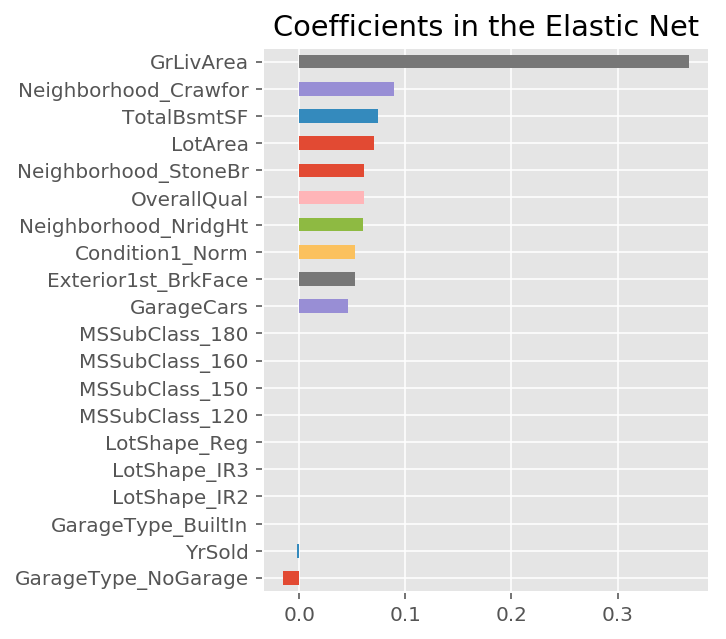

In [643]:
matplotlib.rcParams['figure.figsize'] = (4.0, 5.0)
imp_coef_en.plot(kind = "barh")
plt.title("Coefficients in the Elastic Net")

## Lasso


In [541]:

import numpy as np
param_grid = {'alpha': np.arange(0.0001,0.01,0.0001)}
from sklearn.grid_search import GridSearchCV
from sklearn import linear_model
lasso = linear_model.Lasso()
grid_clf = GridSearchCV(lasso, param_grid, cv =10, scoring = 'neg_mean_squared_error',verbose = 2)

In [542]:
grid_clf.fit(x,y)


Fitting 10 folds for each of 99 candidates, totalling 990 fits
[CV] alpha=0.0001 ....................................................
[CV] ........................................... alpha=0.0001 -   0.0s
[CV] alpha=0.0001 ....................................................
[CV] ........................................... alpha=0.0001 -   0.1s
[CV] alpha=0.0001 ....................................................
[CV] ........................................... alpha=0.0001 -   0.0s
[CV] alpha=0.0001 ....................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] ........................................... alpha=0.0001 -   0.0s
[CV] alpha=0.0001 ....................................................
[CV] ........................................... alpha=0.0001 -   0.0s
[CV] alpha=0.0001 ....................................................
[CV] ........................................... alpha=0.0001 -   0.1s
[CV] alpha=0.0001 ....................................................
[CV] ........................................... alpha=0.0001 -   0.0s
[CV] alpha=0.0001 ....................................................
[CV] ........................................... alpha=0.0001 -   0.0s
[CV] alpha=0.0001 ....................................................
[CV] ........................................... alpha=0.0001 -   0.0s
[CV] alpha=0.0001 ....................................................
[CV] ........................................... alpha=0.0001 -   0.1s
[CV] alpha=0.0002 ....................................................
[CV] .

[CV] ............................ alpha=0.0007000000000000001 -   0.0s
[CV] alpha=0.0007000000000000001 .....................................
[CV] ............................ alpha=0.0007000000000000001 -   0.0s
[CV] alpha=0.0007000000000000001 .....................................
[CV] ............................ alpha=0.0007000000000000001 -   0.0s
[CV] alpha=0.0007000000000000001 .....................................
[CV] ............................ alpha=0.0007000000000000001 -   0.0s
[CV] alpha=0.0007000000000000001 .....................................
[CV] ............................ alpha=0.0007000000000000001 -   0.0s
[CV] alpha=0.0007000000000000001 .....................................
[CV] ............................ alpha=0.0007000000000000001 -   0.0s
[CV] alpha=0.0008 ....................................................
[CV] ........................................... alpha=0.0008 -   0.0s
[CV] alpha=0.0008 ....................................................
[CV] .

[CV] ............................ alpha=0.0013000000000000002 -   0.0s
[CV] alpha=0.0013000000000000002 .....................................
[CV] ............................ alpha=0.0013000000000000002 -   0.0s
[CV] alpha=0.0013000000000000002 .....................................
[CV] ............................ alpha=0.0013000000000000002 -   0.0s
[CV] alpha=0.0014000000000000002 .....................................
[CV] ............................ alpha=0.0014000000000000002 -   0.0s
[CV] alpha=0.0014000000000000002 .....................................
[CV] ............................ alpha=0.0014000000000000002 -   0.0s
[CV] alpha=0.0014000000000000002 .....................................
[CV] ............................ alpha=0.0014000000000000002 -   0.0s
[CV] alpha=0.0014000000000000002 .....................................
[CV] ............................ alpha=0.0014000000000000002 -   0.0s
[CV] alpha=0.0014000000000000002 .....................................
[CV] .

[CV] ............................................ alpha=0.002 -   0.0s
[CV] alpha=0.002 .....................................................
[CV] ............................................ alpha=0.002 -   0.0s
[CV] alpha=0.002 .....................................................
[CV] ............................................ alpha=0.002 -   0.0s
[CV] alpha=0.002 .....................................................
[CV] ............................................ alpha=0.002 -   0.0s
[CV] alpha=0.002 .....................................................
[CV] ............................................ alpha=0.002 -   0.0s
[CV] alpha=0.002 .....................................................
[CV] ............................................ alpha=0.002 -   0.0s
[CV] alpha=0.002 .....................................................
[CV] ............................................ alpha=0.002 -   0.0s
[CV] alpha=0.002 .....................................................
[CV] .

[CV] ........................................... alpha=0.0026 -   0.0s
[CV] alpha=0.0027 ....................................................
[CV] ........................................... alpha=0.0027 -   0.0s
[CV] alpha=0.0027 ....................................................
[CV] ........................................... alpha=0.0027 -   0.0s
[CV] alpha=0.0027 ....................................................
[CV] ........................................... alpha=0.0027 -   0.0s
[CV] alpha=0.0027 ....................................................
[CV] ........................................... alpha=0.0027 -   0.0s
[CV] alpha=0.0027 ....................................................
[CV] ........................................... alpha=0.0027 -   0.0s
[CV] alpha=0.0027 ....................................................
[CV] ........................................... alpha=0.0027 -   0.0s
[CV] alpha=0.0027 ....................................................
[CV] .

[CV] ........................................... alpha=0.0032 -   0.0s
[CV] alpha=0.0033 ....................................................
[CV] ........................................... alpha=0.0033 -   0.0s
[CV] alpha=0.0033 ....................................................
[CV] ........................................... alpha=0.0033 -   0.0s
[CV] alpha=0.0033 ....................................................
[CV] ........................................... alpha=0.0033 -   0.0s
[CV] alpha=0.0033 ....................................................
[CV] ........................................... alpha=0.0033 -   0.0s
[CV] alpha=0.0033 ....................................................
[CV] ........................................... alpha=0.0033 -   0.0s
[CV] alpha=0.0033 ....................................................
[CV] ........................................... alpha=0.0033 -   0.0s
[CV] alpha=0.0033 ....................................................
[CV] .

[CV] ........................................... alpha=0.0039 -   0.0s
[CV] alpha=0.0039 ....................................................
[CV] ........................................... alpha=0.0039 -   0.0s
[CV] alpha=0.0039 ....................................................
[CV] ........................................... alpha=0.0039 -   0.0s
[CV] alpha=0.0039 ....................................................
[CV] ........................................... alpha=0.0039 -   0.0s
[CV] alpha=0.0039 ....................................................
[CV] ........................................... alpha=0.0039 -   0.0s
[CV] alpha=0.0039 ....................................................
[CV] ........................................... alpha=0.0039 -   0.0s
[CV] alpha=0.0039 ....................................................
[CV] ........................................... alpha=0.0039 -   0.0s
[CV] alpha=0.004 .....................................................
[CV] .

[CV] ............................ alpha=0.0045000000000000005 -   0.0s
[CV] alpha=0.0045000000000000005 .....................................
[CV] ............................ alpha=0.0045000000000000005 -   0.0s
[CV] alpha=0.004600000000000001 ......................................
[CV] ............................. alpha=0.004600000000000001 -   0.0s
[CV] alpha=0.004600000000000001 ......................................
[CV] ............................. alpha=0.004600000000000001 -   0.0s
[CV] alpha=0.004600000000000001 ......................................
[CV] ............................. alpha=0.004600000000000001 -   0.0s
[CV] alpha=0.004600000000000001 ......................................
[CV] ............................. alpha=0.004600000000000001 -   0.0s
[CV] alpha=0.004600000000000001 ......................................
[CV] ............................. alpha=0.004600000000000001 -   0.0s
[CV] alpha=0.004600000000000001 ......................................
[CV] .

[CV] ............................. alpha=0.005200000000000001 -   0.0s
[CV] alpha=0.005200000000000001 ......................................
[CV] ............................. alpha=0.005200000000000001 -   0.0s
[CV] alpha=0.005200000000000001 ......................................
[CV] ............................. alpha=0.005200000000000001 -   0.0s
[CV] alpha=0.005300000000000001 ......................................
[CV] ............................. alpha=0.005300000000000001 -   0.0s
[CV] alpha=0.005300000000000001 ......................................
[CV] ............................. alpha=0.005300000000000001 -   0.0s
[CV] alpha=0.005300000000000001 ......................................
[CV] ............................. alpha=0.005300000000000001 -   0.0s
[CV] alpha=0.005300000000000001 ......................................
[CV] ............................. alpha=0.005300000000000001 -   0.0s
[CV] alpha=0.005300000000000001 ......................................
[CV] .

[CV] ............................. alpha=0.005900000000000001 -   0.0s
[CV] alpha=0.005900000000000001 ......................................
[CV] ............................. alpha=0.005900000000000001 -   0.0s
[CV] alpha=0.005900000000000001 ......................................
[CV] ............................. alpha=0.005900000000000001 -   0.0s
[CV] alpha=0.005900000000000001 ......................................
[CV] ............................. alpha=0.005900000000000001 -   0.0s
[CV] alpha=0.005900000000000001 ......................................
[CV] ............................. alpha=0.005900000000000001 -   0.0s
[CV] alpha=0.006 .....................................................
[CV] ............................................ alpha=0.006 -   0.0s
[CV] alpha=0.006 .....................................................
[CV] ............................................ alpha=0.006 -   0.0s
[CV] alpha=0.006 .....................................................
[CV] .

[CV] ............................. alpha=0.006600000000000001 -   0.0s
[CV] alpha=0.006600000000000001 ......................................
[CV] ............................. alpha=0.006600000000000001 -   0.0s
[CV] alpha=0.006600000000000001 ......................................
[CV] ............................. alpha=0.006600000000000001 -   0.0s
[CV] alpha=0.0067 ....................................................
[CV] ........................................... alpha=0.0067 -   0.0s
[CV] alpha=0.0067 ....................................................
[CV] ........................................... alpha=0.0067 -   0.0s
[CV] alpha=0.0067 ....................................................
[CV] ........................................... alpha=0.0067 -   0.0s
[CV] alpha=0.0067 ....................................................
[CV] ........................................... alpha=0.0067 -   0.0s
[CV] alpha=0.0067 ....................................................
[CV] .

[CV] ............................. alpha=0.007300000000000001 -   0.0s
[CV] alpha=0.0074 ....................................................
[CV] ........................................... alpha=0.0074 -   0.0s
[CV] alpha=0.0074 ....................................................
[CV] ........................................... alpha=0.0074 -   0.0s
[CV] alpha=0.0074 ....................................................
[CV] ........................................... alpha=0.0074 -   0.0s
[CV] alpha=0.0074 ....................................................
[CV] ........................................... alpha=0.0074 -   0.0s
[CV] alpha=0.0074 ....................................................
[CV] ........................................... alpha=0.0074 -   0.0s
[CV] alpha=0.0074 ....................................................
[CV] ........................................... alpha=0.0074 -   0.0s
[CV] alpha=0.0074 ....................................................
[CV] .

[CV] ........................................... alpha=0.0079 -   0.0s
[CV] alpha=0.0079 ....................................................
[CV] ........................................... alpha=0.0079 -   0.0s
[CV] alpha=0.008 .....................................................
[CV] ............................................ alpha=0.008 -   0.0s
[CV] alpha=0.008 .....................................................
[CV] ............................................ alpha=0.008 -   0.0s
[CV] alpha=0.008 .....................................................
[CV] ............................................ alpha=0.008 -   0.0s
[CV] alpha=0.008 .....................................................
[CV] ............................................ alpha=0.008 -   0.0s
[CV] alpha=0.008 .....................................................
[CV] ............................................ alpha=0.008 -   0.0s
[CV] alpha=0.008 .....................................................
[CV] .

[CV] ........................................... alpha=0.0085 -   0.0s
[CV] alpha=0.0085 ....................................................
[CV] ........................................... alpha=0.0085 -   0.0s
[CV] alpha=0.0086 ....................................................
[CV] ........................................... alpha=0.0086 -   0.0s
[CV] alpha=0.0086 ....................................................
[CV] ........................................... alpha=0.0086 -   0.0s
[CV] alpha=0.0086 ....................................................
[CV] ........................................... alpha=0.0086 -   0.0s
[CV] alpha=0.0086 ....................................................
[CV] ........................................... alpha=0.0086 -   0.0s
[CV] alpha=0.0086 ....................................................
[CV] ........................................... alpha=0.0086 -   0.0s
[CV] alpha=0.0086 ....................................................
[CV] .

[CV] ........................................... alpha=0.0091 -   0.0s
[CV] alpha=0.0091 ....................................................
[CV] ........................................... alpha=0.0091 -   0.0s
[CV] alpha=0.0092 ....................................................
[CV] ........................................... alpha=0.0092 -   0.0s
[CV] alpha=0.0092 ....................................................
[CV] ........................................... alpha=0.0092 -   0.0s
[CV] alpha=0.0092 ....................................................
[CV] ........................................... alpha=0.0092 -   0.0s
[CV] alpha=0.0092 ....................................................
[CV] ........................................... alpha=0.0092 -   0.0s
[CV] alpha=0.0092 ....................................................
[CV] ........................................... alpha=0.0092 -   0.0s
[CV] alpha=0.0092 ....................................................
[CV] .

[CV] ........................................... alpha=0.0097 -   0.0s
[CV] alpha=0.0097 ....................................................
[CV] ........................................... alpha=0.0097 -   0.0s
[CV] alpha=0.0097 ....................................................
[CV] ........................................... alpha=0.0097 -   0.0s
[CV] alpha=0.0097 ....................................................
[CV] ........................................... alpha=0.0097 -   0.0s
[CV] alpha=0.0098 ....................................................
[CV] ........................................... alpha=0.0098 -   0.0s
[CV] alpha=0.0098 ....................................................
[CV] ........................................... alpha=0.0098 -   0.0s
[CV] alpha=0.0098 ....................................................
[CV] ........................................... alpha=0.0098 -   0.0s
[CV] alpha=0.0098 ....................................................
[CV] .

[Parallel(n_jobs=1)]: Done 990 out of 990 | elapsed:   14.7s finished


GridSearchCV(cv=10, error_score='raise',
       estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'alpha': array([0.0001, 0.0002, ..., 0.0098, 0.0099])},
       pre_dispatch='2*n_jobs', refit=True,
       scoring='neg_mean_squared_error', verbose=2)

In [543]:
grid_clf.best_estimator_


Lasso(alpha=0.0005, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [544]:

from math import sqrt
sqrt(-grid_clf.best_score_)

0.1233222507303255

In [545]:
model_lasso=LassoCV(alphas = np.arange(0.0001,0.01,0.001)).fit(x, y)

In [634]:
coef = pd.Series(model_lasso.coef_, index = x.columns)

In [637]:
coef_en = pd.Series(model_en.coef_, index = x.columns)

In [640]:
print("en picked " + str(sum(coef_en!= 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

en picked 8 variables and eliminated the other 159 variables


In [548]:
imp_coef = pd.concat([coef.sort_values().head(10),
                     coef.sort_values().tail(10)])

Text(0.5,1,'Coefficients in the Lasso')

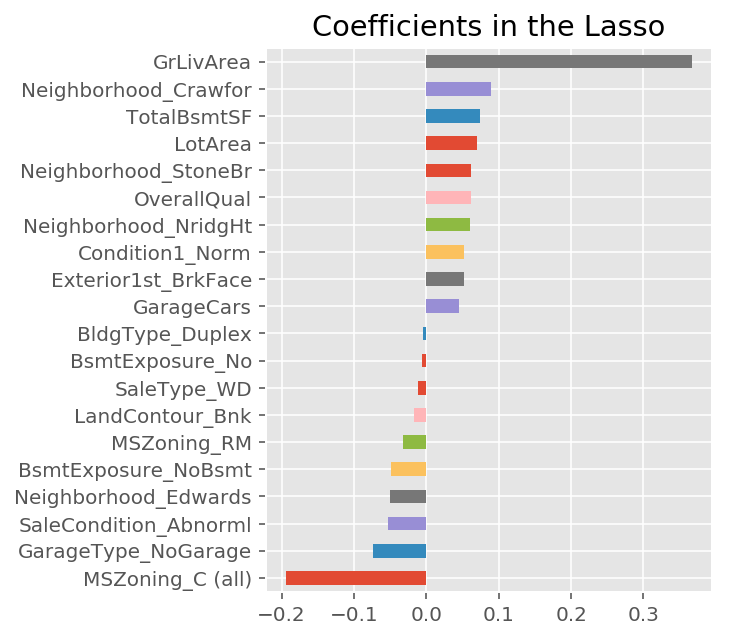

In [641]:
matplotlib.rcParams['figure.figsize'] = (4.0, 5.0)
imp_coef.plot(kind = "barh")
plt.title("Coefficients in the Lasso")

#### 

## Ridge

In [550]:

from sklearn import linear_model
ridge = linear_model.Ridge()
param_grid_2 = {'alpha': np.arange(0.1,1,0.01)}
grid_rd = GridSearchCV(ridge, param_grid_2, cv =10, scoring = 'neg_mean_squared_error',verbose = 2)
grid_rd.fit(x, y)

Fitting 10 folds for each of 90 candidates, totalling 900 fits
[CV] alpha=0.1 .......................................................
[CV] .............................................. alpha=0.1 -   0.0s
[CV] alpha=0.1 .......................................................
[CV] .............................................. alpha=0.1 -   0.0s
[CV] alpha=0.1 .......................................................
[CV] .............................................. alpha=0.1 -   0.0s
[CV] alpha=0.1 .......................................................
[CV] .............................................. alpha=0.1 -   0.0s
[CV] alpha=0.1 .......................................................
[CV] .............................................. alpha=0.1 -   0.0s
[CV] alpha=0.1 .......................................................
[CV] .............................................. alpha=0.1 -   0.0s
[CV] alpha=0.1 .......................................................
[CV] .........

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] ............................................. alpha=0.12 -   0.0s
[CV] alpha=0.12 ......................................................
[CV] ............................................. alpha=0.12 -   0.0s
[CV] alpha=0.12 ......................................................
[CV] ............................................. alpha=0.12 -   0.0s
[CV] alpha=0.12 ......................................................
[CV] ............................................. alpha=0.12 -   0.0s
[CV] alpha=0.12 ......................................................
[CV] ............................................. alpha=0.12 -   0.0s
[CV] alpha=0.12 ......................................................
[CV] ............................................. alpha=0.12 -   0.0s
[CV] alpha=0.12 ......................................................
[CV] ............................................. alpha=0.12 -   0.0s
[CV] alpha=0.12 ......................................................
[CV] .

[CV] .............................. alpha=0.18999999999999995 -   0.0s
[CV] alpha=0.18999999999999995 .......................................
[CV] .............................. alpha=0.18999999999999995 -   0.0s
[CV] alpha=0.18999999999999995 .......................................
[CV] .............................. alpha=0.18999999999999995 -   0.0s
[CV] alpha=0.18999999999999995 .......................................
[CV] .............................. alpha=0.18999999999999995 -   0.0s
[CV] alpha=0.18999999999999995 .......................................
[CV] .............................. alpha=0.18999999999999995 -   0.0s
[CV] alpha=0.18999999999999995 .......................................
[CV] .............................. alpha=0.18999999999999995 -   0.0s
[CV] alpha=0.18999999999999995 .......................................
[CV] .............................. alpha=0.18999999999999995 -   0.0s
[CV] alpha=0.18999999999999995 .......................................
[CV] .

[CV] ............................... alpha=0.2599999999999999 -   0.0s
[CV] alpha=0.2599999999999999 ........................................
[CV] ............................... alpha=0.2599999999999999 -   0.0s
[CV] alpha=0.2599999999999999 ........................................
[CV] ............................... alpha=0.2599999999999999 -   0.0s
[CV] alpha=0.2599999999999999 ........................................
[CV] ............................... alpha=0.2599999999999999 -   0.0s
[CV] alpha=0.2599999999999999 ........................................
[CV] ............................... alpha=0.2599999999999999 -   0.0s
[CV] alpha=0.2599999999999999 ........................................
[CV] ............................... alpha=0.2599999999999999 -   0.0s
[CV] alpha=0.2599999999999999 ........................................
[CV] ............................... alpha=0.2599999999999999 -   0.0s
[CV] alpha=0.2599999999999999 ........................................
[CV] .

[CV] .............................. alpha=0.32999999999999985 -   0.0s
[CV] alpha=0.32999999999999985 .......................................
[CV] .............................. alpha=0.32999999999999985 -   0.0s
[CV] alpha=0.32999999999999985 .......................................
[CV] .............................. alpha=0.32999999999999985 -   0.0s
[CV] alpha=0.32999999999999985 .......................................
[CV] .............................. alpha=0.32999999999999985 -   0.0s
[CV] alpha=0.32999999999999985 .......................................
[CV] .............................. alpha=0.32999999999999985 -   0.0s
[CV] alpha=0.32999999999999985 .......................................
[CV] .............................. alpha=0.32999999999999985 -   0.0s
[CV] alpha=0.32999999999999985 .......................................
[CV] .............................. alpha=0.32999999999999985 -   0.0s
[CV] alpha=0.32999999999999985 .......................................
[CV] .

[CV] ............................... alpha=0.3999999999999998 -   0.0s
[CV] alpha=0.3999999999999998 ........................................
[CV] ............................... alpha=0.3999999999999998 -   0.0s
[CV] alpha=0.3999999999999998 ........................................
[CV] ............................... alpha=0.3999999999999998 -   0.0s
[CV] alpha=0.3999999999999998 ........................................
[CV] ............................... alpha=0.3999999999999998 -   0.0s
[CV] alpha=0.3999999999999998 ........................................
[CV] ............................... alpha=0.3999999999999998 -   0.0s
[CV] alpha=0.3999999999999998 ........................................
[CV] ............................... alpha=0.3999999999999998 -   0.0s
[CV] alpha=0.3999999999999998 ........................................
[CV] ............................... alpha=0.3999999999999998 -   0.0s
[CV] alpha=0.4099999999999998 ........................................
[CV] .

[CV] .............................. alpha=0.46999999999999986 -   0.0s
[CV] alpha=0.46999999999999986 .......................................
[CV] .............................. alpha=0.46999999999999986 -   0.0s
[CV] alpha=0.46999999999999986 .......................................
[CV] .............................. alpha=0.46999999999999986 -   0.0s
[CV] alpha=0.47999999999999976 .......................................
[CV] .............................. alpha=0.47999999999999976 -   0.0s
[CV] alpha=0.47999999999999976 .......................................
[CV] .............................. alpha=0.47999999999999976 -   0.0s
[CV] alpha=0.47999999999999976 .......................................
[CV] .............................. alpha=0.47999999999999976 -   0.0s
[CV] alpha=0.47999999999999976 .......................................
[CV] .............................. alpha=0.47999999999999976 -   0.0s
[CV] alpha=0.47999999999999976 .......................................
[CV] .

[CV] ............................... alpha=0.5499999999999998 -   0.0s
[CV] alpha=0.5499999999999998 ........................................
[CV] ............................... alpha=0.5499999999999998 -   0.0s
[CV] alpha=0.5499999999999998 ........................................
[CV] ............................... alpha=0.5499999999999998 -   0.0s
[CV] alpha=0.5499999999999998 ........................................
[CV] ............................... alpha=0.5499999999999998 -   0.0s
[CV] alpha=0.5499999999999998 ........................................
[CV] ............................... alpha=0.5499999999999998 -   0.0s
[CV] alpha=0.5499999999999998 ........................................
[CV] ............................... alpha=0.5499999999999998 -   0.0s
[CV] alpha=0.5499999999999998 ........................................
[CV] ............................... alpha=0.5499999999999998 -   0.0s
[CV] alpha=0.5499999999999998 ........................................
[CV] .

[CV] ............................... alpha=0.6199999999999998 -   0.0s
[CV] alpha=0.6299999999999997 ........................................
[CV] ............................... alpha=0.6299999999999997 -   0.0s
[CV] alpha=0.6299999999999997 ........................................
[CV] ............................... alpha=0.6299999999999997 -   0.0s
[CV] alpha=0.6299999999999997 ........................................
[CV] ............................... alpha=0.6299999999999997 -   0.0s
[CV] alpha=0.6299999999999997 ........................................
[CV] ............................... alpha=0.6299999999999997 -   0.0s
[CV] alpha=0.6299999999999997 ........................................
[CV] ............................... alpha=0.6299999999999997 -   0.0s
[CV] alpha=0.6299999999999997 ........................................
[CV] ............................... alpha=0.6299999999999997 -   0.0s
[CV] alpha=0.6299999999999997 ........................................
[CV] .

[CV] ............................... alpha=0.6999999999999996 -   0.0s
[CV] alpha=0.6999999999999996 ........................................
[CV] ............................... alpha=0.6999999999999996 -   0.0s
[CV] alpha=0.6999999999999996 ........................................
[CV] ............................... alpha=0.6999999999999996 -   0.0s
[CV] alpha=0.6999999999999996 ........................................
[CV] ............................... alpha=0.6999999999999996 -   0.0s
[CV] alpha=0.6999999999999996 ........................................
[CV] ............................... alpha=0.6999999999999996 -   0.0s
[CV] alpha=0.7099999999999996 ........................................
[CV] ............................... alpha=0.7099999999999996 -   0.0s
[CV] alpha=0.7099999999999996 ........................................
[CV] ............................... alpha=0.7099999999999996 -   0.0s
[CV] alpha=0.7099999999999996 ........................................
[CV] .

[CV] ............................... alpha=0.7799999999999997 -   0.0s
[CV] alpha=0.7799999999999997 ........................................
[CV] ............................... alpha=0.7799999999999997 -   0.0s
[CV] alpha=0.7799999999999997 ........................................
[CV] ............................... alpha=0.7799999999999997 -   0.0s
[CV] alpha=0.7799999999999997 ........................................
[CV] ............................... alpha=0.7799999999999997 -   0.0s
[CV] alpha=0.7799999999999997 ........................................
[CV] ............................... alpha=0.7799999999999997 -   0.0s
[CV] alpha=0.7799999999999997 ........................................
[CV] ............................... alpha=0.7799999999999997 -   0.0s
[CV] alpha=0.7799999999999997 ........................................
[CV] ............................... alpha=0.7799999999999997 -   0.0s
[CV] alpha=0.7799999999999997 ........................................
[CV] .

[CV] ............................... alpha=0.8499999999999996 -   0.0s
[CV] alpha=0.8499999999999996 ........................................
[CV] ............................... alpha=0.8499999999999996 -   0.0s
[CV] alpha=0.8599999999999995 ........................................
[CV] ............................... alpha=0.8599999999999995 -   0.0s
[CV] alpha=0.8599999999999995 ........................................
[CV] ............................... alpha=0.8599999999999995 -   0.0s
[CV] alpha=0.8599999999999995 ........................................
[CV] ............................... alpha=0.8599999999999995 -   0.0s
[CV] alpha=0.8599999999999995 ........................................
[CV] ............................... alpha=0.8599999999999995 -   0.0s
[CV] alpha=0.8599999999999995 ........................................
[CV] ............................... alpha=0.8599999999999995 -   0.0s
[CV] alpha=0.8599999999999995 ........................................
[CV] .

[CV] ............................... alpha=0.9299999999999996 -   0.0s
[CV] alpha=0.9299999999999996 ........................................
[CV] ............................... alpha=0.9299999999999996 -   0.0s
[CV] alpha=0.9299999999999996 ........................................
[CV] ............................... alpha=0.9299999999999996 -   0.0s
[CV] alpha=0.9299999999999996 ........................................
[CV] ............................... alpha=0.9299999999999996 -   0.0s
[CV] alpha=0.9299999999999996 ........................................
[CV] ............................... alpha=0.9299999999999996 -   0.0s
[CV] alpha=0.9299999999999996 ........................................
[CV] ............................... alpha=0.9299999999999996 -   0.0s
[CV] alpha=0.9299999999999996 ........................................
[CV] ............................... alpha=0.9299999999999996 -   0.0s
[CV] alpha=0.9399999999999996 ........................................
[CV] .

[Parallel(n_jobs=1)]: Done 900 out of 900 | elapsed:    7.6s finished


GridSearchCV(cv=10, error_score='raise',
       estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'alpha': array([0.1 , 0.11, ..., 0.98, 0.99])},
       pre_dispatch='2*n_jobs', refit=True,
       scoring='neg_mean_squared_error', verbose=2)

In [551]:
from math import sqrt
sqrt(-grid_rd.best_score_)

0.1283450540493493

In [552]:
grid_rd.best_estimator_


Ridge(alpha=0.9899999999999995, copy_X=True, fit_intercept=True,
   max_iter=None, normalize=False, random_state=None, solver='auto',
   tol=0.001)

In [553]:
model_ridge=RidgeCV(alphas= np.arange(0.1,1,0.01)).fit(x, y)

In [554]:
model_en=ElasticNetCV(alphas= np.arange(0.1,1,0.01)).fit(x, y)

In [652]:
coef_r = pd.Series(model_ridge.coef_, index = x.columns)
print("r picked " + str(sum(coef_r!= 0)) + " variables and eliminated the other " +  str(sum(coef_r == 0)) + " variables")


r picked 224 variables and eliminated the other 1 variables


In [556]:
imp_coef_r = pd.concat([coef.sort_values().head(10),
                     coef.sort_values().tail(10)])

Text(0.5,1,'Coefficients in the Ridge')

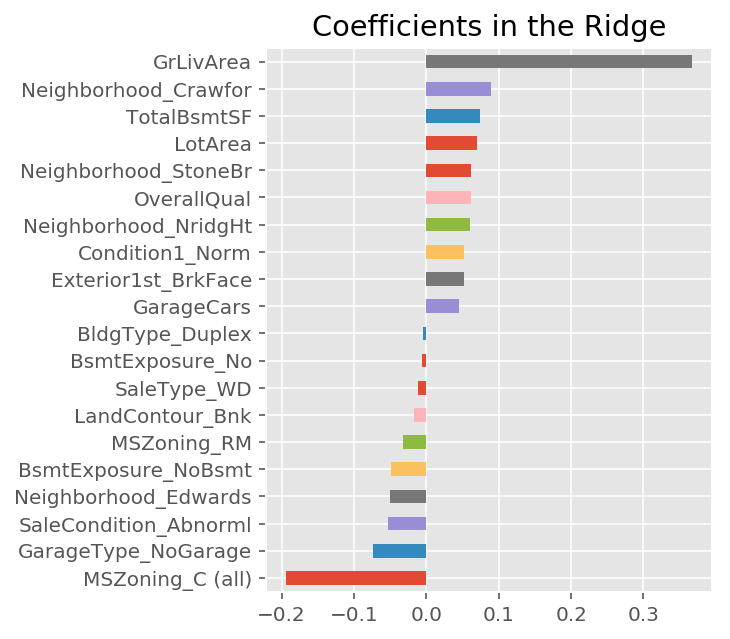

In [642]:
matplotlib.rcParams['figure.figsize'] = (4.0, 5.0)
imp_coef_r.plot(kind = "barh")
plt.title("Coefficients in the Ridge")

In [609]:
from sklearn.linear_model import Ridge,RidgeCV,ElasticNet,ElasticNetCV,Lasso,LassoCV
from sklearn.model_selection import cross_val_score

def rmse_cv(model):
    rmse= np.sqrt(-cross_val_score(model, x, y, scoring="neg_mean_squared_error", cv = 10))
    return(rmse)

In [610]:
alphas= np.arange(0.01,1,0.01)
cv_ridge = [rmse_cv(Ridge(alpha = alpha)).mean() 
            for alpha in alphas]



In [611]:
alphas_1=np.arange(0.0001,0.01,0.001)
cv_en = [rmse_cv(ElasticNet(alpha = alpha)).mean() 
            for alpha in alphas_1]

In [612]:
alphas_2=np.arange(0.0001,0.01,0.001)
cv_l = [rmse_cv(Lasso(alpha = alpha)).mean() 
            for alpha in alphas_2]


Text(0,0.5,'rmse')

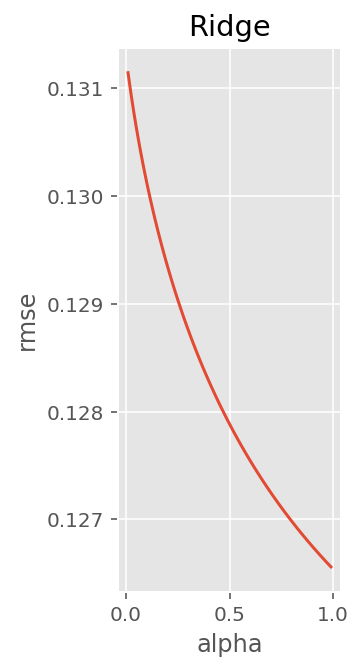

In [616]:
cv_ridge = pd.Series(cv_ridge,index = alphas)
matplotlib.rcParams['figure.figsize'] = (2.0, 5.0)
cv_ridg4e.plot(title = "Ridge")
plt.xlabel("alpha")
plt.ylabel("rmse")

Text(0,0.5,'rmse')

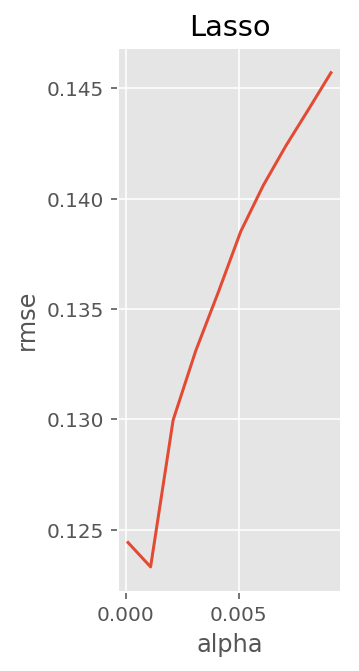

In [607]:
cv_lasso = pd.Series(cv_l,index = alphas_2)
matplotlib.rcParams['figure.figsize'] = (2.0, 5.0)
l=cv_lasso.plot(title = "Lasso")
plt.xlabel("alpha")
plt.ylabel("rmse")

Text(0,0.5,'rmse')

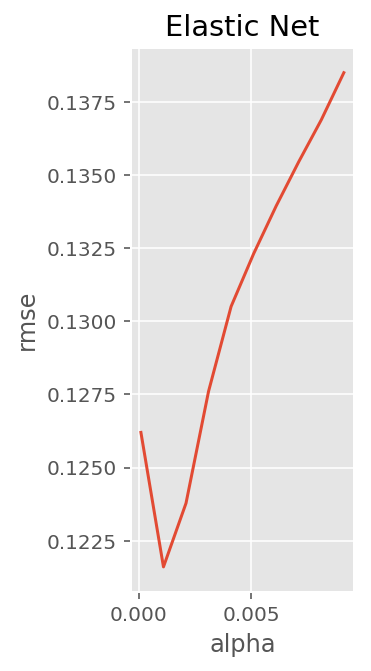

In [626]:
cv_en = pd.Series(cv_en,index = alphas_1)
matplotlib.rcParams['figure.figsize'] = (2.0, 5.0)
cv_en.plot(title = "Elastic Net")
plt.xlabel("alpha")
plt.ylabel("rmse")


KeyError: 'residuals'

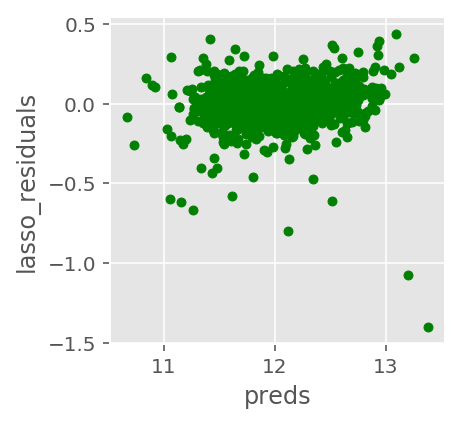

In [629]:
matplotlib.rcParams['figure.figsize'] = (3, 3.0)

preds_lasso = pd.DataFrame({"preds":model_lasso.predict(x), "true":y})
preds_lasso["lasso_residuals"] = preds_lasso["true"] - preds_lasso["preds"]
p1=preds_lasso.plot(x = "preds", y = "lasso_residuals",kind = "scatter",color='g')
preds_lasso_r=preds_lasso["residuals"].tolist()


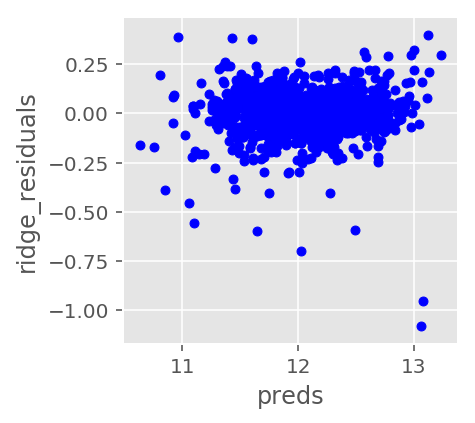

In [630]:
matplotlib.rcParams['figure.figsize'] = (3, 3.0)

preds_ridge = pd.DataFrame({"preds":model_ridge.predict(x), "true":y})
preds_ridge["riresiduals"] = preds_ridge["true"] - preds_ridge["preds"]
p2=preds_ridge.plot(x = "preds", y = "residuals",kind = "scatter",color='b')
p2


matplotlib.rcParams['figure.figsize'] = (3, 3)

preds_en = pd.DataFrame({"preds":model_en.predict(x), "true":y})
preds_en["residuals"] = preds_en["true"] - preds_en["preds"]
p3=preds_en.plot(x = "preds", y = "residuals",kind = "scatter",color='r')


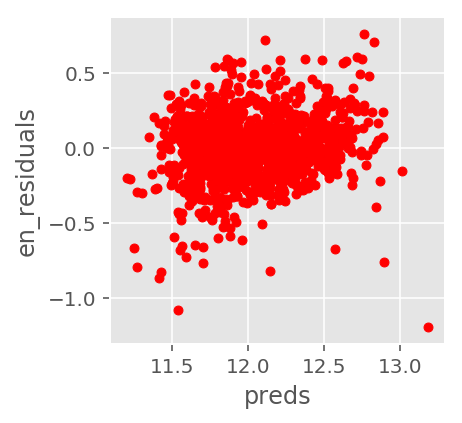

In [632]:
matplotlib.rcParams['figure.figsize'] = (3, 3)

preds_en = pd.DataFrame({"preds":model_en.predict(x), "true":y})
preds_en["en_residuals"] = preds_en["true"] - preds_en["preds"]
p3=preds_en.plot(x = "preds", y = "en_residuals",kind = "scatter",color='r')

#### preds=pd.DataFrame(preds_en["residuals"],preds_ridge["residuals"])
preds

In [571]:
%matplotlib inline
from matplotlib import pyplot as plt
plt.style.use('ggplot')

In [572]:

preds.plot(x=["", y=["A", "B", "C"], kind="bar")


SyntaxError: invalid syntax (<ipython-input-572-691ab437ba38>, line 2)